In [ ]:
!pip install yellowbrick
!pip install optuna

In [1]:
import pandas as pd
import optuna
import time
import concurrent.futures
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import PredictionError

# Base de Dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#path = "/content/drive/MyDrive/Dissertação/dados/procucao_gado_MS.csv"
path = "../../dados/df_train_regression.csv"
df = pd.read_csv(path, sep=';')

In [3]:
print('A base de dados apresenta {} registros e {} características.'.format(df.shape[0], df.shape[1]))

A base de dados apresenta 672657 registros e 48 características.


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tipificacao_1,672657.0,0.491430,0.499927,0.000000,0.000000,0.00000,1.000000,1.000000
tipificacao_2,672657.0,0.223876,0.416840,0.000000,0.000000,0.00000,0.000000,1.000000
tipificacao_3,672657.0,0.284693,0.451269,0.000000,0.000000,0.00000,1.000000,1.000000
classificacao_estabelecimento,672657.0,24.469376,3.620986,21.000000,21.000000,26.00000,26.000000,30.000000
outros_incentivos,672657.0,0.054300,0.226608,0.000000,0.000000,0.00000,0.000000,1.000000
pratica_recuperacao_pastagem,672657.0,0.592659,0.491340,0.000000,0.000000,1.00000,1.000000,1.000000
fertiirrigacao,672657.0,0.094448,0.292451,0.000000,0.000000,0.00000,0.000000,1.000000
ilp,672657.0,0.419834,0.493532,0.000000,0.000000,0.00000,1.000000,1.000000
ilpf,672657.0,0.048707,0.215255,0.000000,0.000000,0.00000,0.000000,1.000000
ifp,672657.0,0.048853,0.215560,0.000000,0.000000,0.00000,0.000000,1.000000


### Separando as características preditoras do atributo alvo

In [4]:
y = df['peso']
# Retirar a variável alvo e as variáveis obtidas após o abate 
X = df.drop(['peso'],axis=1)

In [5]:
SEED = 42

In [6]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Treinando o modelo com *Random Forest Regression* (RFR)
Passos a serem executados:


1. Reescala dos dados como a tecnica StandardScaler;
2. Redução da dimensionalidade com PCA, para reduzir o número de recursos e ajudar a acelerar o treinamento do modelo Random Forest;
3. Ajuste de hiperparâmetros para tentar otimizar o desempenho do modelo utilizando o framework Optuna. 
4. Validação cruzada do modelo com os melhores hiperparâmetros encontrados
5. Descobrir quais são os recursos mais relevantes para o modelo.

### StandardScaler

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### PCA 
Instanciamos a função PCA e definimos o número de componentes (recursos) que queremos considerar. Vamos defini-lo como "40" para ver a variação explicada de todos os componentes gerados, antes de decidir onde fazer o corte. 

In [10]:
pca_test = PCA(n_components=40)
pca_test.fit(X_scaled)

PCA(n_components=40)

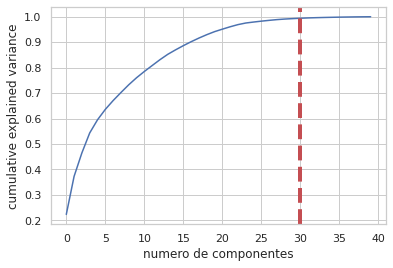

None

In [ ]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('numero de componentes')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=30, ymin=0, ymax=1)
display(plt.show())

Este gráfico mostra que depois de mais de 30 componentes, não ganhamos muita variância explicada.

In [ ]:
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(40))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.223556,0.223556
1,0.373074,0.149518
2,0.465195,0.092120
3,0.543392,0.078198
4,0.594985,0.051592
5,0.635870,0.040885
6,0.670435,0.034565
7,0.701972,0.031538
8,0.732459,0.030487
9,0.760056,0.027597


O dataframe mostra a Razão de Variação Acumulada (quanta variação total dos dados é explicada) e a Razão de Variação Explicada (quanto cada componente do PCA explica a variação total dos dados).

In [8]:
pca = PCA(n_components=30)
pca.fit(X_scaled)
X_scaled_pca = pca.transform(X_scaled)

## Random Forest Regressor (RFR) - Baseline

In [11]:
rfr_baseline = RandomForestRegressor(n_jobs=-1)
scores = cross_val_score(rfr_baseline, X_scaled_pca, y, n_jobs=-1, cv=kfolds, scoring='r2')

In [12]:
print('Média %.3f +/- %.2f' % (scores.mean(), scores.std()))

Média 0.778 +/- 0.00


## Otimização dos hiperparâmetros

In [9]:
# Manipulador de fluxo para mostrar as mensagens
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "rfr-study"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
# storage_name = "sqlite:///content/drive/MyDrive/Dissertação/dados/{}.db".format(study_name)

In [10]:
# função de otimização baseada em uma função objetivo
def tune(objective):
    study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="maximize")
    study.optimize(objective, timeout=86400, n_trials=100)

    params = study.best_params
    print(f"Trial: {study.best_trial.number}")
    params = study.best_params
    print("\n")
    print(f"Melhor seleção de parâmetros : \n{params}")
    print("\n")
    print(f"Acurácia : {study.best_value:.3f}")
    
    return study, params

In [11]:
def randomforest_objective(trial: optuna.Trial): 
    rfr_params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 300),
        "max_depth":  trial.suggest_int("max_depth", 10, 200),
        "min_samples_split" : trial.suggest_int("min_samples_split", 5, 50),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", 
                                                  choices=["auto", "sqrt", "log2"]
                                                  ),
        "bootstrap": trial.suggest_categorical("bootstrap", 
                                               choices=["True", "False"]
                                               ),
        "random_state": SEED,
    }
    rfr = RandomForestRegressor(**rfr_params, n_jobs=-1)
    scores = cross_val_score(rfr, X_scaled_pca, y, n_jobs=-1, cv=kfolds, scoring='r2')
    return scores.mean()

In [12]:
t0 = time.time()
study, best_rfr_params = tune(randomforest_objective)  
print("Pronto em:  %0.3f" %(time.time()-t0))

[I 2022-05-04 22:38:34,660] Using an existing study with name 'rfr-study' instead of creating a new one.


Using an existing study with name 'rfr-study' instead of creating a new one.


[I 2022-05-04 22:53:05,827] Trial 90 finished with value: 0.7783826924476139 and parameters: {'n_estimators': 270, 'max_depth': 115, 'min_samples_split': 39, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 37 with value: 0.7783951601151406.


Trial 90 finished with value: 0.7783826924476139 and parameters: {'n_estimators': 270, 'max_depth': 115, 'min_samples_split': 39, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 37 with value: 0.7783951601151406.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-04 23:07:29,799] Trial 91 finished with value: 0.7783895126810881 and parameters: {'n_estimators': 282, 'max_depth': 143, 'min_samples_split': 37, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 37 with value: 0.7783951601151406.


Trial 91 finished with value: 0.7783895126810881 and parameters: {'n_estimators': 282, 'max_depth': 143, 'min_samples_split': 37, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 37 with value: 0.7783951601151406.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-04 23:21:06,067] Trial 92 finished with value: 0.7783973221866435 and parameters: {'n_estimators': 263, 'max_depth': 117, 'min_samples_split': 38, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 92 with value: 0.7783973221866435.


Trial 92 finished with value: 0.7783973221866435 and parameters: {'n_estimators': 263, 'max_depth': 117, 'min_samples_split': 38, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 92 with value: 0.7783973221866435.


[I 2022-05-04 23:34:14,494] Trial 93 finished with value: 0.7783986592847856 and parameters: {'n_estimators': 256, 'max_depth': 133, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 93 finished with value: 0.7783986592847856 and parameters: {'n_estimators': 256, 'max_depth': 133, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-04 23:47:20,050] Trial 94 finished with value: 0.7783907991720206 and parameters: {'n_estimators': 261, 'max_depth': 134, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 94 finished with value: 0.7783907991720206 and parameters: {'n_estimators': 261, 'max_depth': 134, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


[I 2022-05-04 23:58:54,534] Trial 95 finished with value: 0.7778200508650464 and parameters: {'n_estimators': 230, 'max_depth': 137, 'min_samples_split': 29, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 95 finished with value: 0.7778200508650464 and parameters: {'n_estimators': 230, 'max_depth': 137, 'min_samples_split': 29, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


[I 2022-05-05 00:10:57,473] Trial 96 finished with value: 0.7783435622234609 and parameters: {'n_estimators': 240, 'max_depth': 134, 'min_samples_split': 34, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 96 finished with value: 0.7783435622234609 and parameters: {'n_estimators': 240, 'max_depth': 134, 'min_samples_split': 34, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


[I 2022-05-05 00:23:47,053] Trial 97 finished with value: 0.7773289043793308 and parameters: {'n_estimators': 254, 'max_depth': 126, 'min_samples_split': 32, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 97 finished with value: 0.7773289043793308 and parameters: {'n_estimators': 254, 'max_depth': 126, 'min_samples_split': 32, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 00:34:47,789] Trial 98 finished with value: 0.7783550108526824 and parameters: {'n_estimators': 219, 'max_depth': 116, 'min_samples_split': 25, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 98 finished with value: 0.7783550108526824 and parameters: {'n_estimators': 219, 'max_depth': 116, 'min_samples_split': 25, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


[I 2022-05-05 01:59:50,131] Trial 99 finished with value: 0.7782136148219084 and parameters: {'n_estimators': 272, 'max_depth': 145, 'min_samples_split': 33, 'min_samples_leaf': 2, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 99 finished with value: 0.7782136148219084 and parameters: {'n_estimators': 272, 'max_depth': 145, 'min_samples_split': 33, 'min_samples_leaf': 2, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 02:13:51,696] Trial 100 finished with value: 0.7774802303239944 and parameters: {'n_estimators': 283, 'max_depth': 109, 'min_samples_split': 31, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 100 finished with value: 0.7774802303239944 and parameters: {'n_estimators': 283, 'max_depth': 109, 'min_samples_split': 31, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


[I 2022-05-05 02:27:04,557] Trial 101 finished with value: 0.778396899689294 and parameters: {'n_estimators': 260, 'max_depth': 141, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 101 finished with value: 0.778396899689294 and parameters: {'n_estimators': 260, 'max_depth': 141, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


[I 2022-05-05 02:40:03,765] Trial 102 finished with value: 0.7783961615927741 and parameters: {'n_estimators': 263, 'max_depth': 152, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 102 finished with value: 0.7783961615927741 and parameters: {'n_estimators': 263, 'max_depth': 152, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


[I 2022-05-05 02:53:15,703] Trial 103 finished with value: 0.7783920387421441 and parameters: {'n_estimators': 265, 'max_depth': 162, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 103 finished with value: 0.7783920387421441 and parameters: {'n_estimators': 265, 'max_depth': 162, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


[I 2022-05-05 03:05:36,499] Trial 104 finished with value: 0.7783956673231776 and parameters: {'n_estimators': 244, 'max_depth': 163, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 104 finished with value: 0.7783956673231776 and parameters: {'n_estimators': 244, 'max_depth': 163, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 03:17:41,824] Trial 105 finished with value: 0.7783959898612981 and parameters: {'n_estimators': 245, 'max_depth': 151, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 105 finished with value: 0.7783959898612981 and parameters: {'n_estimators': 245, 'max_depth': 151, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


[I 2022-05-05 03:29:45,409] Trial 106 finished with value: 0.7783956673231776 and parameters: {'n_estimators': 244, 'max_depth': 154, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 106 finished with value: 0.7783956673231776 and parameters: {'n_estimators': 244, 'max_depth': 154, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


[I 2022-05-05 03:42:02,771] Trial 107 finished with value: 0.7783303135105101 and parameters: {'n_estimators': 244, 'max_depth': 167, 'min_samples_split': 35, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


Trial 107 finished with value: 0.7783303135105101 and parameters: {'n_estimators': 244, 'max_depth': 167, 'min_samples_split': 35, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 93 with value: 0.7783986592847856.


[I 2022-05-05 03:53:40,256] Trial 108 finished with value: 0.778398881236744 and parameters: {'n_estimators': 233, 'max_depth': 155, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 108 finished with value: 0.778398881236744 and parameters: {'n_estimators': 233, 'max_depth': 155, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 04:04:47,390] Trial 109 finished with value: 0.778395346830775 and parameters: {'n_estimators': 222, 'max_depth': 153, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 109 finished with value: 0.778395346830775 and parameters: {'n_estimators': 222, 'max_depth': 153, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 04:16:27,582] Trial 110 finished with value: 0.7783437342291692 and parameters: {'n_estimators': 232, 'max_depth': 150, 'min_samples_split': 34, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 110 finished with value: 0.7783437342291692 and parameters: {'n_estimators': 232, 'max_depth': 150, 'min_samples_split': 34, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 04:27:14,025] Trial 111 finished with value: 0.7783864197764647 and parameters: {'n_estimators': 215, 'max_depth': 154, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 111 finished with value: 0.7783864197764647 and parameters: {'n_estimators': 215, 'max_depth': 154, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 04:38:21,067] Trial 112 finished with value: 0.7783918323969784 and parameters: {'n_estimators': 225, 'max_depth': 160, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 112 finished with value: 0.7783918323969784 and parameters: {'n_estimators': 225, 'max_depth': 160, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 04:50:29,929] Trial 113 finished with value: 0.7783960318493881 and parameters: {'n_estimators': 248, 'max_depth': 166, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 113 finished with value: 0.7783960318493881 and parameters: {'n_estimators': 248, 'max_depth': 166, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 05:02:52,200] Trial 114 finished with value: 0.7783960318493881 and parameters: {'n_estimators': 248, 'max_depth': 167, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 114 finished with value: 0.7783960318493881 and parameters: {'n_estimators': 248, 'max_depth': 167, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 05:14:49,590] Trial 115 finished with value: 0.7783857011062963 and parameters: {'n_estimators': 238, 'max_depth': 169, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 115 finished with value: 0.7783857011062963 and parameters: {'n_estimators': 238, 'max_depth': 169, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 05:26:59,662] Trial 116 finished with value: 0.7783932092165434 and parameters: {'n_estimators': 247, 'max_depth': 180, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 116 finished with value: 0.7783932092165434 and parameters: {'n_estimators': 247, 'max_depth': 180, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 05:38:39,306] Trial 117 finished with value: 0.7783848019481621 and parameters: {'n_estimators': 234, 'max_depth': 165, 'min_samples_split': 31, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 117 finished with value: 0.7783848019481621 and parameters: {'n_estimators': 234, 'max_depth': 165, 'min_samples_split': 31, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 05:50:33,211] Trial 118 finished with value: 0.7783438336342866 and parameters: {'n_estimators': 243, 'max_depth': 174, 'min_samples_split': 34, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 118 finished with value: 0.7783438336342866 and parameters: {'n_estimators': 243, 'max_depth': 174, 'min_samples_split': 34, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 06:03:06,097] Trial 119 finished with value: 0.7783940898985856 and parameters: {'n_estimators': 253, 'max_depth': 158, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 119 finished with value: 0.7783940898985856 and parameters: {'n_estimators': 253, 'max_depth': 158, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 06:14:42,964] Trial 120 finished with value: 0.7783255885509159 and parameters: {'n_estimators': 231, 'max_depth': 147, 'min_samples_split': 28, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 120 finished with value: 0.7783255885509159 and parameters: {'n_estimators': 231, 'max_depth': 147, 'min_samples_split': 28, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 06:27:37,789] Trial 121 finished with value: 0.7783946917783793 and parameters: {'n_estimators': 256, 'max_depth': 157, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 121 finished with value: 0.7783946917783793 and parameters: {'n_estimators': 256, 'max_depth': 157, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 06:40:16,711] Trial 122 finished with value: 0.7783939424495439 and parameters: {'n_estimators': 255, 'max_depth': 152, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 122 finished with value: 0.7783939424495439 and parameters: {'n_estimators': 255, 'max_depth': 152, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 06:52:31,445] Trial 123 finished with value: 0.7783932092165434 and parameters: {'n_estimators': 247, 'max_depth': 171, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 123 finished with value: 0.7783932092165434 and parameters: {'n_estimators': 247, 'max_depth': 171, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 07:01:42,590] Trial 124 finished with value: 0.7783802684796914 and parameters: {'n_estimators': 186, 'max_depth': 161, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 124 finished with value: 0.7783802684796914 and parameters: {'n_estimators': 186, 'max_depth': 161, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 07:12:38,550] Trial 125 finished with value: 0.7783852665535453 and parameters: {'n_estimators': 222, 'max_depth': 193, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 125 finished with value: 0.7783852665535453 and parameters: {'n_estimators': 222, 'max_depth': 193, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 08:29:21,898] Trial 126 finished with value: 0.7782413447009158 and parameters: {'n_estimators': 249, 'max_depth': 157, 'min_samples_split': 39, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 126 finished with value: 0.7782413447009158 and parameters: {'n_estimators': 249, 'max_depth': 157, 'min_samples_split': 39, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 08:41:10,399] Trial 127 finished with value: 0.7780418860832073 and parameters: {'n_estimators': 238, 'max_depth': 165, 'min_samples_split': 34, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 127 finished with value: 0.7780418860832073 and parameters: {'n_estimators': 238, 'max_depth': 165, 'min_samples_split': 34, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 08:54:10,032] Trial 128 finished with value: 0.7783875535822864 and parameters: {'n_estimators': 257, 'max_depth': 148, 'min_samples_split': 31, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 128 finished with value: 0.7783875535822864 and parameters: {'n_estimators': 257, 'max_depth': 148, 'min_samples_split': 31, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 09:06:01,376] Trial 129 finished with value: 0.7783435622234609 and parameters: {'n_estimators': 240, 'max_depth': 155, 'min_samples_split': 34, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 129 finished with value: 0.7783435622234609 and parameters: {'n_estimators': 240, 'max_depth': 155, 'min_samples_split': 34, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 09:17:05,007] Trial 130 finished with value: 0.778391573133695 and parameters: {'n_estimators': 227, 'max_depth': 153, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 130 finished with value: 0.778391573133695 and parameters: {'n_estimators': 227, 'max_depth': 153, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 09:29:30,757] Trial 131 finished with value: 0.7783939340837945 and parameters: {'n_estimators': 252, 'max_depth': 160, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 131 finished with value: 0.7783939340837945 and parameters: {'n_estimators': 252, 'max_depth': 160, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 09:42:08,022] Trial 132 finished with value: 0.7783938330340654 and parameters: {'n_estimators': 254, 'max_depth': 158, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 132 finished with value: 0.7783938330340654 and parameters: {'n_estimators': 254, 'max_depth': 158, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 09:53:58,977] Trial 133 finished with value: 0.7783934555532648 and parameters: {'n_estimators': 244, 'max_depth': 171, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 133 finished with value: 0.7783934555532648 and parameters: {'n_estimators': 244, 'max_depth': 171, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 10:06:41,512] Trial 134 finished with value: 0.7783827998523368 and parameters: {'n_estimators': 259, 'max_depth': 178, 'min_samples_split': 39, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 134 finished with value: 0.7783827998523368 and parameters: {'n_estimators': 259, 'max_depth': 178, 'min_samples_split': 39, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 10:18:43,932] Trial 135 finished with value: 0.7783911507955569 and parameters: {'n_estimators': 249, 'max_depth': 163, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 135 finished with value: 0.7783911507955569 and parameters: {'n_estimators': 249, 'max_depth': 163, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 10:30:19,187] Trial 136 finished with value: 0.7783914245901519 and parameters: {'n_estimators': 235, 'max_depth': 142, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 136 finished with value: 0.7783914245901519 and parameters: {'n_estimators': 235, 'max_depth': 142, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 10:41:00,531] Trial 137 finished with value: 0.7783930707351006 and parameters: {'n_estimators': 216, 'max_depth': 150, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 137 finished with value: 0.7783930707351006 and parameters: {'n_estimators': 216, 'max_depth': 150, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 10:53:44,799] Trial 138 finished with value: 0.7781260966172303 and parameters: {'n_estimators': 261, 'max_depth': 146, 'min_samples_split': 38, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 138 finished with value: 0.7781260966172303 and parameters: {'n_estimators': 261, 'max_depth': 146, 'min_samples_split': 38, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 11:04:11,036] Trial 139 finished with value: 0.7783829656776705 and parameters: {'n_estimators': 209, 'max_depth': 183, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 139 finished with value: 0.7783829656776705 and parameters: {'n_estimators': 209, 'max_depth': 183, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 11:16:16,922] Trial 140 finished with value: 0.7783293241811093 and parameters: {'n_estimators': 244, 'max_depth': 167, 'min_samples_split': 37, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 140 finished with value: 0.7783293241811093 and parameters: {'n_estimators': 244, 'max_depth': 167, 'min_samples_split': 37, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 11:28:41,465] Trial 141 finished with value: 0.7783939424495439 and parameters: {'n_estimators': 255, 'max_depth': 153, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 141 finished with value: 0.7783939424495439 and parameters: {'n_estimators': 255, 'max_depth': 153, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 11:42:05,704] Trial 142 finished with value: 0.7783954151894565 and parameters: {'n_estimators': 273, 'max_depth': 139, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 142 finished with value: 0.7783954151894565 and parameters: {'n_estimators': 273, 'max_depth': 139, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 11:55:23,771] Trial 143 finished with value: 0.7783966524172665 and parameters: {'n_estimators': 272, 'max_depth': 156, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 143 finished with value: 0.7783966524172665 and parameters: {'n_estimators': 272, 'max_depth': 156, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 12:09:08,723] Trial 144 finished with value: 0.7783951994292204 and parameters: {'n_estimators': 275, 'max_depth': 139, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 144 finished with value: 0.7783951994292204 and parameters: {'n_estimators': 275, 'max_depth': 139, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 12:22:37,130] Trial 145 finished with value: 0.7783931966958206 and parameters: {'n_estimators': 273, 'max_depth': 139, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 145 finished with value: 0.7783931966958206 and parameters: {'n_estimators': 273, 'max_depth': 139, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 12:38:23,717] Trial 146 finished with value: 0.778382051444609 and parameters: {'n_estimators': 272, 'max_depth': 139, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 146 finished with value: 0.778382051444609 and parameters: {'n_estimators': 272, 'max_depth': 139, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 12:51:55,027] Trial 147 finished with value: 0.7783852494609673 and parameters: {'n_estimators': 279, 'max_depth': 136, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 147 finished with value: 0.7783852494609673 and parameters: {'n_estimators': 279, 'max_depth': 136, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 13:04:45,675] Trial 148 finished with value: 0.7783980525948541 and parameters: {'n_estimators': 265, 'max_depth': 144, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 148 finished with value: 0.7783980525948541 and parameters: {'n_estimators': 265, 'max_depth': 144, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 13:18:29,825] Trial 149 finished with value: 0.7783433390780715 and parameters: {'n_estimators': 277, 'max_depth': 151, 'min_samples_split': 34, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 149 finished with value: 0.7783433390780715 and parameters: {'n_estimators': 277, 'max_depth': 151, 'min_samples_split': 34, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 14:39:24,411] Trial 150 finished with value: 0.7782433044116331 and parameters: {'n_estimators': 264, 'max_depth': 144, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 150 finished with value: 0.7782433044116331 and parameters: {'n_estimators': 264, 'max_depth': 144, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 14:52:34,631] Trial 151 finished with value: 0.778398065296776 and parameters: {'n_estimators': 269, 'max_depth': 131, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 151 finished with value: 0.778398065296776 and parameters: {'n_estimators': 269, 'max_depth': 131, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 15:05:55,264] Trial 152 finished with value: 0.7783889065032941 and parameters: {'n_estimators': 269, 'max_depth': 147, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 152 finished with value: 0.7783889065032941 and parameters: {'n_estimators': 269, 'max_depth': 147, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 15:18:44,177] Trial 153 finished with value: 0.7783977990112892 and parameters: {'n_estimators': 264, 'max_depth': 132, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 153 finished with value: 0.7783977990112892 and parameters: {'n_estimators': 264, 'max_depth': 132, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 15:19:26,153] Trial 154 finished with value: 0.7778507965980574 and parameters: {'n_estimators': 14, 'max_depth': 132, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 154 finished with value: 0.7778507965980574 and parameters: {'n_estimators': 14, 'max_depth': 132, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 15:32:07,266] Trial 155 finished with value: 0.7783961615927741 and parameters: {'n_estimators': 263, 'max_depth': 127, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 155 finished with value: 0.7783961615927741 and parameters: {'n_estimators': 263, 'max_depth': 127, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 15:44:45,082] Trial 156 finished with value: 0.7783964266198116 and parameters: {'n_estimators': 262, 'max_depth': 129, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 156 finished with value: 0.7783964266198116 and parameters: {'n_estimators': 262, 'max_depth': 129, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 15:57:41,336] Trial 157 finished with value: 0.7782642293647938 and parameters: {'n_estimators': 264, 'max_depth': 125, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 157 finished with value: 0.7782642293647938 and parameters: {'n_estimators': 264, 'max_depth': 125, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 16:10:04,718] Trial 158 finished with value: 0.778393605542721 and parameters: {'n_estimators': 261, 'max_depth': 128, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 158 finished with value: 0.778393605542721 and parameters: {'n_estimators': 261, 'max_depth': 128, 'min_samples_split': 36, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 16:22:30,956] Trial 159 finished with value: 0.7783290759381647 and parameters: {'n_estimators': 262, 'max_depth': 124, 'min_samples_split': 31, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 159 finished with value: 0.7783290759381647 and parameters: {'n_estimators': 262, 'max_depth': 124, 'min_samples_split': 31, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 16:23:44,327] Trial 160 finished with value: 0.7781590258282292 and parameters: {'n_estimators': 25, 'max_depth': 132, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 160 finished with value: 0.7781590258282292 and parameters: {'n_estimators': 25, 'max_depth': 132, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 16:36:26,465] Trial 161 finished with value: 0.7783961418018799 and parameters: {'n_estimators': 268, 'max_depth': 142, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 161 finished with value: 0.7783961418018799 and parameters: {'n_estimators': 268, 'max_depth': 142, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 16:49:18,494] Trial 162 finished with value: 0.7783905192100985 and parameters: {'n_estimators': 265, 'max_depth': 135, 'min_samples_split': 37, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 162 finished with value: 0.7783905192100985 and parameters: {'n_estimators': 265, 'max_depth': 135, 'min_samples_split': 37, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 17:02:21,910] Trial 163 finished with value: 0.778398065296776 and parameters: {'n_estimators': 269, 'max_depth': 127, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 163 finished with value: 0.778398065296776 and parameters: {'n_estimators': 269, 'max_depth': 127, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 17:15:23,378] Trial 164 finished with value: 0.7783942522069982 and parameters: {'n_estimators': 269, 'max_depth': 128, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


Trial 164 finished with value: 0.7783942522069982 and parameters: {'n_estimators': 269, 'max_depth': 128, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 108 with value: 0.778398881236744.


[I 2022-05-05 17:28:53,061] Trial 165 finished with value: 0.7783995068404417 and parameters: {'n_estimators': 277, 'max_depth': 143, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 165 with value: 0.7783995068404417.


Trial 165 finished with value: 0.7783995068404417 and parameters: {'n_estimators': 277, 'max_depth': 143, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 165 with value: 0.7783995068404417.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 17:42:35,459] Trial 166 finished with value: 0.7783990326334023 and parameters: {'n_estimators': 290, 'max_depth': 132, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 165 with value: 0.7783995068404417.


Trial 166 finished with value: 0.7783990326334023 and parameters: {'n_estimators': 290, 'max_depth': 132, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 165 with value: 0.7783995068404417.


[I 2022-05-05 17:56:05,235] Trial 167 finished with value: 0.7784001554600031 and parameters: {'n_estimators': 280, 'max_depth': 133, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 167 finished with value: 0.7784001554600031 and parameters: {'n_estimators': 280, 'max_depth': 133, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 18:10:02,919] Trial 168 finished with value: 0.7783907350911516 and parameters: {'n_estimators': 288, 'max_depth': 131, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 168 finished with value: 0.7783907350911516 and parameters: {'n_estimators': 288, 'max_depth': 131, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 18:24:12,400] Trial 169 finished with value: 0.7783985167936479 and parameters: {'n_estimators': 296, 'max_depth': 122, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 169 finished with value: 0.7783985167936479 and parameters: {'n_estimators': 296, 'max_depth': 122, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 18:38:06,361] Trial 170 finished with value: 0.7783445636833832 and parameters: {'n_estimators': 291, 'max_depth': 120, 'min_samples_split': 34, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 170 finished with value: 0.7783445636833832 and parameters: {'n_estimators': 291, 'max_depth': 120, 'min_samples_split': 34, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 18:52:26,235] Trial 171 finished with value: 0.7783983092591578 and parameters: {'n_estimators': 299, 'max_depth': 123, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 171 finished with value: 0.7783983092591578 and parameters: {'n_estimators': 299, 'max_depth': 123, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 19:06:51,295] Trial 172 finished with value: 0.7783916647774551 and parameters: {'n_estimators': 300, 'max_depth': 125, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 172 finished with value: 0.7783916647774551 and parameters: {'n_estimators': 300, 'max_depth': 125, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 19:20:45,802] Trial 173 finished with value: 0.7783975364429536 and parameters: {'n_estimators': 291, 'max_depth': 135, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 173 finished with value: 0.7783975364429536 and parameters: {'n_estimators': 291, 'max_depth': 135, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 19:34:49,340] Trial 174 finished with value: 0.7776447078565487 and parameters: {'n_estimators': 294, 'max_depth': 136, 'min_samples_split': 31, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 174 finished with value: 0.7776447078565487 and parameters: {'n_estimators': 294, 'max_depth': 136, 'min_samples_split': 31, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 19:49:04,166] Trial 175 finished with value: 0.7783976095872795 and parameters: {'n_estimators': 294, 'max_depth': 128, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 175 finished with value: 0.7783976095872795 and parameters: {'n_estimators': 294, 'max_depth': 128, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 20:03:21,659] Trial 176 finished with value: 0.7783878981179331 and parameters: {'n_estimators': 295, 'max_depth': 131, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 176 finished with value: 0.7783878981179331 and parameters: {'n_estimators': 295, 'max_depth': 131, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 20:19:34,794] Trial 177 finished with value: 0.7783865734673413 and parameters: {'n_estimators': 286, 'max_depth': 122, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 177 finished with value: 0.7783865734673413 and parameters: {'n_estimators': 286, 'max_depth': 122, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 20:34:39,027] Trial 178 finished with value: 0.7783989196966563 and parameters: {'n_estimators': 282, 'max_depth': 127, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 178 finished with value: 0.7783989196966563 and parameters: {'n_estimators': 282, 'max_depth': 127, 'min_samples_split': 34, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 20:48:22,666] Trial 179 finished with value: 0.7783968017185356 and parameters: {'n_estimators': 281, 'max_depth': 134, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 179 finished with value: 0.7783968017185356 and parameters: {'n_estimators': 281, 'max_depth': 134, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 21:03:13,316] Trial 180 finished with value: 0.7783718818947962 and parameters: {'n_estimators': 281, 'max_depth': 134, 'min_samples_split': 29, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 180 finished with value: 0.7783718818947962 and parameters: {'n_estimators': 281, 'max_depth': 134, 'min_samples_split': 29, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 21:17:40,604] Trial 181 finished with value: 0.7783979339672324 and parameters: {'n_estimators': 297, 'max_depth': 129, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 181 finished with value: 0.7783979339672324 and parameters: {'n_estimators': 297, 'max_depth': 129, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 21:32:40,091] Trial 182 finished with value: 0.7783903382241275 and parameters: {'n_estimators': 297, 'max_depth': 123, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 182 finished with value: 0.7783903382241275 and parameters: {'n_estimators': 297, 'max_depth': 123, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 21:46:44,785] Trial 183 finished with value: 0.7783967824635784 and parameters: {'n_estimators': 289, 'max_depth': 135, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 183 finished with value: 0.7783967824635784 and parameters: {'n_estimators': 289, 'max_depth': 135, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 22:00:28,636] Trial 184 finished with value: 0.778392062993172 and parameters: {'n_estimators': 287, 'max_depth': 135, 'min_samples_split': 31, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 184 finished with value: 0.778392062993172 and parameters: {'n_estimators': 287, 'max_depth': 135, 'min_samples_split': 31, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


/home/inara/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[I 2022-05-05 22:14:33,273] Trial 185 finished with value: 0.7783975364429536 and parameters: {'n_estimators': 291, 'max_depth': 130, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 185 finished with value: 0.7783975364429536 and parameters: {'n_estimators': 291, 'max_depth': 130, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 22:29:03,172] Trial 186 finished with value: 0.7783984924938275 and parameters: {'n_estimators': 300, 'max_depth': 117, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 186 finished with value: 0.7783984924938275 and parameters: {'n_estimators': 300, 'max_depth': 117, 'min_samples_split': 33, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


[I 2022-05-05 23:59:02,755] Trial 187 finished with value: 0.7782482659204708 and parameters: {'n_estimators': 299, 'max_depth': 117, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.


Trial 187 finished with value: 0.7782482659204708 and parameters: {'n_estimators': 299, 'max_depth': 117, 'min_samples_split': 32, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 167 with value: 0.7784001554600031.
Trial: 167


Melhor seleção de parâmetros : 
{'bootstrap': 'True', 'max_depth': 133, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 34, 'n_estimators': 280}


Acurácia : 0.778
Pronto em:  91228.223


In [ ]:
#Para uso no colab
from google.colab import files
files.download('/content/sample_data/xgb-study.db')

In [2]:
# Determina quais hiperparâmetros tiveram o impacto mais significativo no desempenho geral do modelo.
optuna.visualization.plot_param_importances(study)

NameError: ignored

## Treinando o modelo com os melhores Hiperparâmetros

In [ ]:
#melhores hiperparametros obtidos do processo de otimização
params={'n_estimators': 280, 'max_depth': 29, 'min_samples_split': 43, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 'True'}

In [ ]:
model_rfr = RandomForestRegressor(n_jobs=-1, random_state=SEED, **params)
model_rfr

RandomForestRegressor(bootstrap='True', max_depth=29, max_features='log2',
                      min_samples_split=43, n_estimators=280, n_jobs=-1,
                      random_state=42)

### Validação Cruzada com 10 folds

In [ ]:
def validacao(modelo, X, y):
    cv =  KFold(n_splits= 10, shuffle=True)
    scores = cross_validate(modelo, X, y, cv = cv, 
                            scoring=('r2', 'neg_mean_absolute_error','neg_root_mean_squared_error'),
                            return_train_score=True,
                            n_jobs=-1)
    resultados_cross_validate(scores, nome_metrica='test_r2')
    resultados_cross_validate(scores, nome_metrica='test_neg_mean_absolute_error')
    resultados_cross_validate(scores, nome_metrica='test_neg_root_mean_squared_error')

In [ ]:
def resultados_cross_validate(scores, nome_metrica):
    media = scores [nome_metrica].mean()
    desvio_padrao = scores[nome_metrica].std()
    print('Métrica ' + nome_metrica + ': ' )
    print('Média %.3f +/- %.2f' % (media, desvio_padrao))
    print('Intervalo: [ %.3f, %.3f ]'  % (min(scores [nome_metrica]), max(scores [nome_metrica])))
    print('\n')

In [ ]:
validacao(model_rfr, X_scaled_pca, y)

Métrica test_r2: 
Média 0.780 +/- 0.00
Intervalo: [ 0.778, 0.783 ]


Métrica test_neg_mean_absolute_error: 
Média -15.772 +/- 0.05
Intervalo: [ -15.847, -15.700 ]


Métrica test_neg_root_mean_squared_error: 
Média -20.815 +/- 0.07
Intervalo: [ -20.907, -20.723 ]




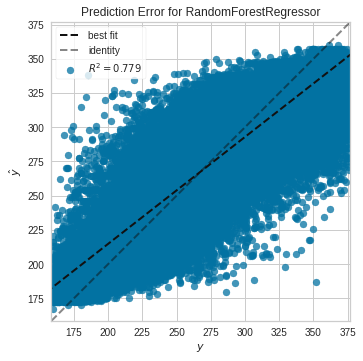

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_pca, y, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(n_jobs=-1, random_state=SEED, **params)
visualizer = PredictionError(rfr)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.poof() 

## Analisando a importância de cada variável

In [ ]:
rfr = RandomForestRegressor(n_jobs=-1, random_state=SEED, **params)
rfr.fit(X, y)

RandomForestRegressor(bootstrap='True', max_depth=29, max_features='log2',
                      min_samples_split=43, n_estimators=280, n_jobs=-1,
                      random_state=42)

In [ ]:
nomes_caracteristicas = []
for i in X.columns:
    nomes_caracteristicas.append(i)

In [ ]:
importancia = rfr.feature_importances_
# Importâncias de características são fornecidas pelo atributo ajustado feature_importances_ 
# e são calculadas como a média e o desvio padrão de acumulação da diminuição de impurezas dentro de cada árvore.
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)

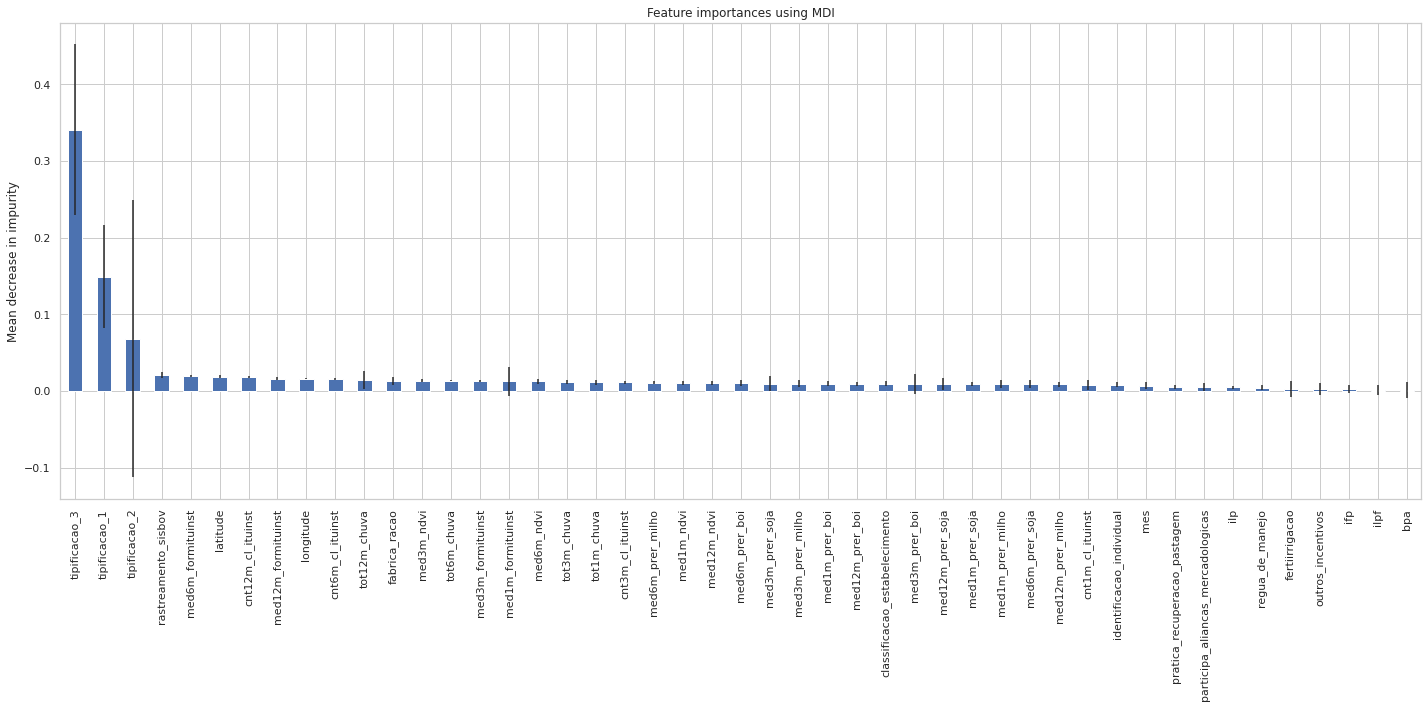

In [ ]:
forest_importances = pd.Series(importancia, index=nomes_caracteristicas)
forest_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### RFE (Recursive Feature Elimination)


In [ ]:
# O RFE tem como parametro o número de recursos a serem selecionados. Se nenhum valor for informado, metade dos recursos são selecionados. 
# A iteração abaixo visa encontrar o melhor valor para este parâmetro dentro de um intervalo. 

def num_recursos_selecao(min, max, estimator) :
    # nº de recursos a serem testados dentro do intervalo 10 a 30
    nof_list=np.arange(min,max) 
    # Variável para armazenar o melhor score encontrado            
    high_score=0
    # Variável para armazenar os numero de recursos ideal 
    nof=0           
    score_list =[]
    for n in range(len(nof_list)):
        X_train, X_test, y_train, y_test = train_test_split(,y,test_size = 0.3, random_state = 0)
        rfe = RFE(estimator,n_features_to_select = nof_list[n])
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        estimator.fit(X_train_rfe,y_train)
        score = estimator.score(X_test_rfe,y_test)
        score_list.append(score)
        print("Score com %d recursos: %f" % (nof_list[n], score))
        if(score>high_score):
            high_score = score
            nof = nof_list[n]
    print("====================================")
    print("Número ideal de recursos: %d" %nof)
    print("Score com %d recursos: %f" % (nof, high_score))

In [ ]:
# Retorna os n recusos mais significativos
def selecao_rfe(n) :
    model = RandomForestRegressor(n_jobs=-1, random_state=SEED, **params)
    #Inicializando o modelo RFE
    rfe = RFE(model, n_features_to_select = n)
    X_rfe = rfe.fit_transform(X,y)  
    #Treinando o modelo
    model.fit(X_rfe,y)  
    cols = list(X.columns)            
    temp = pd.Series(rfe.support_,index = cols)
    selected_features_rfe = temp[temp==True].index
    return selected_features_rfe

In [ ]:
estimator = RandomForestRegressor(n_jobs=-1, random_state=SEED, **params)
num_recursos_selecao(10, 31, estimator)

Score com 10 recursos: 0.759605
Score com 11 recursos: 0.759566
Score com 12 recursos: 0.759843
Score com 13 recursos: 0.759807
Score com 14 recursos: 0.768200
Score com 15 recursos: 0.768200
Score com 16 recursos: 0.768432
Score com 17 recursos: 0.768378
Score com 18 recursos: 0.768398
Score com 19 recursos: 0.768367
Score com 20 recursos: 0.774587
Score com 21 recursos: 0.774592
Score com 22 recursos: 0.774610
Score com 23 recursos: 0.774561
Score com 24 recursos: 0.776684
Score com 25 recursos: 0.776662
Score com 26 recursos: 0.776668
Score com 27 recursos: 0.776654
Score com 28 recursos: 0.776655
Score com 29 recursos: 0.776675
Score com 30 recursos: 0.776614
Número ideal de recursos: 24
Score com 24 recursos: 0.776684


In [ ]:
selected_features_rfe = selecao_rfe(24)
selected_features_rfe

Index(['tipificacao_1', 'tipificacao_2', 'tipificacao_3',
       'classificacao_estabelecimento', 'fabrica_racao', 'rastreamento_sisbov',
       'med1m_formituinst', 'med1m_prer_boi', 'tot3m_chuva',
       'med3m_formituinst', 'med3m_ndvi', 'med3m_prer_milho', 'med3m_prer_boi',
       'tot6m_chuva', 'med6m_formituinst', 'med6m_ndvi', 'med6m_prer_milho',
       'med6m_prer_boi', 'tot12m_chuva', 'med12m_formituinst',
       'cnt6m_cl_ituinst', 'cnt12m_cl_ituinst', 'longitude', 'latitude'],
      dtype='object')

In [ ]:
X_selection = df[df.columns.intersection(selected_features_rfe)]

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selection)

In [ ]:
validacao(RandomForestRegressor(n_jobs=-1, random_state=SEED, **params), X_scaled, y)

Métrica test_r2: 
Média 0.777 +/- 0.00
Intervalo: [ 0.773, 0.780 ]


Métrica test_neg_mean_absolute_error: 
Média -15.896 +/- 0.05
Intervalo: [ -15.962, -15.792 ]


Métrica test_neg_root_mean_squared_error: 
Média -20.964 +/- 0.07
Intervalo: [ -21.104, -20.868 ]




## Exportando o modelo

In [ ]:
rfr = RandomForestRegressor(n_jobs=-1, random_state=SEED, **params)
X_train, X_test, y_train, y_test = train_test_split(X_selection,y, test_size = 0.2, random_state = SEED)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap='True', max_depth=29, max_features='log2',
                      min_samples_split=43, n_estimators=280, n_jobs=-1,
                      random_state=42)

In [ ]:
from joblib import dump, load
dump(rfr, '/content/drive/MyDrive/Dissertação/modelo/rfr_model.joblib') 

['/content/drive/MyDrive/Dissertação/modelo/rfr_model.joblib']

In [ ]:
# Para carregar modelo
# from joblib import load
# rfr = load('/content/drive/MyDrive/Dissertação/modelo/rfr_model.joblib') 